## Part III: Matrix Factorization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:

# 1. 为了保证user_id和business_id都在训练集中出现，按user_id分组进行采样
def train_test_split_by_user(df, test_size=0.2):
    train_list = []
    test_list = []

    # 遍历每个用户的评分
    for user_id, group in df.groupby("user_id"):
        # 按照test_size的比例，从用户的交互记录中随机选择数据放入测试集
        test_indices = np.random.choice(
            group.index, size=int(len(group) * test_size), replace=False
        )

        # 分别将记录放入训练集和测试集
        test_list.append(group.loc[test_indices])
        train_list.append(group.drop(test_indices))

    # 合并所有用户的数据，形成最终的训练集和测试集
    train_data = pd.concat(train_list)
    test_data = pd.concat(test_list)

    return train_data, test_data

In [3]:
df = pd.read_csv('./yelp_2020.csv')
df["date"] = pd.to_datetime(df["date"])
df.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,WiFi,GoodForKids,OutdoorSeating,RestaurantsReservations,exist_BusinessAcceptsCreditCards,exist_RestaurantsPriceRange2,exist_BikeParking,exist_RestaurantsTakeOut,exist_RestaurantsDelivery,exist_WiFi
0,J1LZjzbs5bFubvS135SD2g,5TE19zTjTIPq1HANACN7sw,dChRGpit9fM_kZK5pafNyA,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,0,False,True,True,1,1,1,1,1,1
1,ecMiAOFucDM3zwXYfY-Q6A,5Z8S9OsHWCnE8wbxk1poQQ,s3Q1J4XEVOBiZy9dYUpqpg,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,1,NaN,True,False,1,1,1,1,1,1
2,yuFQRhHo3z4TgE6drPXSgg,hcw7ndQKWGEH4P7BYAlG9w,JUlsvVAvZvGHWFfkKm0nlg,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,0,False,True,True,1,1,1,1,1,1
3,Zdh0_HtE724MnohLOrB5Iw,OYaEBYLBrLY4mla8bOMbnA,9b0Mrvs6uJu2jJqet_Jwew,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,1,NaN,NaN,NaN,1,1,1,1,1,1
4,y_XYEZk2Cin-q4N0czeaYw,_9VhEn9zaB-6txE3STNfLw,PYUI1OJVksGUbCrteU68bw,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,1,False,True,True,1,1,1,1,1,1


(array([ 817.,  955.,  792.,  938.,  926.,  935.,  870.,  806.,  818.,
         699.,  957.,  663., 1077.,  964., 1000.,  777., 1064.,  742.,
         950.,  667.,  465.,  259.,  277.,  237.,  266.,  238.,  191.,
         211.,  210.,  221.,  235.,  279.,  203.,  281.,  292.,  340.,
         272.,  350.,  230.,  297.,  294.,  230.,  275.,  339.,  278.,
         336.,  382.,  315.,  403.,  411.,  378.,  403.,  493.,  419.,
         482.,  439.,  543.,  449.,  582.,  439.,  528.,  479.,  514.,
         540.,  519.,  490.,  506.,  485.,  553.,  581.,  567.,  579.,
         626.,  597.,  479.,  597.,  441.,  604.,  496.,  609.,  509.,
         579.,  465.,  496.,  411.,  462.,  457.,  498.,  451.,  476.,
         333.,  515.,  458.,  372.,  409.,  383.,  376.,  327.,  380.,
         395.]),
 array([18262.00459491, 18265.66454005, 18269.32448519, 18272.98443032,
        18276.64437546, 18280.3043206 , 18283.96426574, 18287.62421088,
        18291.28415602, 18294.94410116, 18298.6040463 , 18

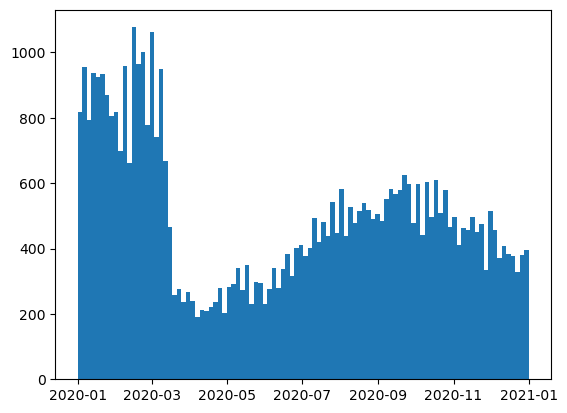

In [4]:
plt.hist(df["date"], bins=100)

In [5]:
def changeID(df):
    user_id_mapping = {id: idx for idx, id in enumerate(df["user_id"].unique())}
    business_id_mapping = {id: idx for idx, id in enumerate(df["business_id"].unique())}

    df["user_id"] = df["user_id"].map(user_id_mapping)
    df["business_id"] = df["business_id"].map(business_id_mapping)

    return df

In [6]:
test_cnt = df[["user_id","business_id","stars_x"]]
usr_item = test_cnt.groupby(["user_id","business_id"]).count()
usr = test_cnt.groupby("user_id").count()

In [7]:
usr_item[usr_item["stars_x"]==1]

stars_x
user_id                business_id                    
--9SwR3jQX-e3opxARFF_g bzAuVc17AxrckfQSXjHhog        1
--Dz7-yZ5vMuDdlHxfBWVw -0TffRSXXIlBYVbb5AwfTg        1
--QuTu4oQehIyk8VCaLVFQ 6pT7TIyrhpeo-LjTlIZBDA        1
--TWMH9cWljAtLBykBtuBA d4llp0qNSbkSxGIMRvYprg        1
--YFsSwR8YRhFwwv9ZkKBw NbOWECn3ilz4gWL6dm5P6g        1
...                                                ...
zzeRWIiPtuJNRBUcxe0Upw NUJrCPU51Cvip4ayZD1P5g        1
                       t2KQa1plnfMoA_LOgBrUGA        1
zzfdOXALn161r4ZlMWc_vw D8NEBGvh1DVHbyEs2cWVAQ        1
                       b66R96v0N-Mmu0jb4cVhiQ        1
zzzMBVS73g3ZJ7qL8JyhiA 3FKIev7ZB_KE6XHL9sUJCg        1

[48752 rows x 1 columns]

In [8]:
df = changeID(df)
df.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,WiFi,GoodForKids,OutdoorSeating,RestaurantsReservations,exist_BusinessAcceptsCreditCards,exist_RestaurantsPriceRange2,exist_BikeParking,exist_RestaurantsTakeOut,exist_RestaurantsDelivery,exist_WiFi
0,J1LZjzbs5bFubvS135SD2g,0,0,5.0,1,0,1,Had a great big meal with family and we loved ...,2020-01-20 00:36:44,The Love,...,0,False,True,True,1,1,1,1,1,1
1,ecMiAOFucDM3zwXYfY-Q6A,1,1,5.0,0,0,0,Many locations. All have lines so be prepared...,2020-02-16 22:52:13,Green Eggs Cafe,...,1,NaN,True,False,1,1,1,1,1,1
2,yuFQRhHo3z4TgE6drPXSgg,2,2,5.0,1,0,0,Compliments to the chef and to the rest of the...,2020-01-12 00:55:58,El Camino Real,...,0,False,True,True,1,1,1,1,1,1
3,Zdh0_HtE724MnohLOrB5Iw,3,3,4.0,0,0,0,I decided to try this spot out -- and it didn'...,2020-01-15 19:29:25,Asia Nail 2 & Spa,...,1,NaN,NaN,NaN,1,1,1,1,1,1
4,y_XYEZk2Cin-q4N0czeaYw,4,4,3.0,0,0,0,"First off, finding parking is atrocious. Your ...",2020-02-17 13:53:51,Bourbon & Branch,...,1,False,True,True,1,1,1,1,1,1


In [9]:
train_data, test_data = train_test_split_by_user(df, test_size=0.4)

train_user_ids = set(train_data["user_id"])
test_user_ids = set(test_data["user_id"])
train_business_ids = set(train_data["business_id"])
test_business_ids = set(test_data["business_id"])

print(len(test_user_ids - train_user_ids))
print(len(test_business_ids - train_business_ids))
# assert test_user_ids.issubset(train_user_ids), "user_id not in train set"
# assert test_business_ids.issubset(
#     train_business_ids
# ), "business_id not in train set"

test_data = test_data[test_data["business_id"].isin(train_business_ids)]

train_data = train_data[["user_id", "business_id", "stars_x"]]
test_data = test_data[["user_id", "business_id", "stars_x"]]

print("Train data:")
print(len(train_data))
print("\nTest data:")
print(len(test_data))

0
303
Train data:
42416

Test data:
7451


In [10]:
test_data.head()

,user_id,business_id,stars_x
41933,0,6266,4.0
33508,1,5295,2.0
27351,2,4062,3.0
25941,2,3951,3.0
36954,2,5527,5.0


In [11]:
# class of factorization
class MatrixFactorization:
    def __init__(self, ratings, K, alpha, beta, iterations):
        """
        ratings: user-item rating matrix
        K: hidden dimension
        alpha: learning rate
        beta: regularization parameter
        iterations: number of iterations
        """
        self.R = ratings
        self.num_users, self.num_items = ratings.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self, val_data):

        self.P = np.random.normal(scale=1.0 / self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0 / self.K, size=(self.num_items, self.K))


        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R > 0])

        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        for iteration in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()

            mse = self.train_mse()
            val_error = self.val_mse(val_data)
            print(f"Iteration: {iteration+1}; error = {mse:.4f}; val_error = {val_error:.4f}")

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.predict(i, j)
            error = r - prediction


            self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (
                error * self.Q[j, :] - self.beta * self.P[i, :]
            )
            self.Q[j, :] += self.alpha * (
                error * self.P[i, :] - self.beta * self.Q[j, :]
            )

    def predict(self, i, j):
        prediction = (
            self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        )
        return prediction

    def train_mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        train_error = 0
        for x, y in zip(xs, ys):
            train_error += (self.R[x, y] - predicted[x, y]) ** 2
        return np.sqrt(train_error / len(xs))

    def val_mse(self, val_data):
        val_error = 0
        for row in val_data.itertuples():
            i = int(row.user_id)
            j = int(row.business_id)
            r = row.stars_x
            prediction = self.predict(i, j)
            val_error += (r - prediction) ** 2
        return np.sqrt(val_error / len(val_data))


    def full_matrix(self):
        return (
            self.b
            + self.b_u[:, np.newaxis]
            + self.b_i[np.newaxis :,]
            + self.P.dot(self.Q.T)
        )

In [12]:

num_users = df["user_id"].nunique()
num_items = df["business_id"].nunique()

train_ratings = np.zeros((num_users, num_items))

for row in train_data.itertuples():
    train_ratings[row.user_id, row.business_id] = row.stars_x


mf = MatrixFactorization(train_ratings, K=2, alpha=0.01, beta=0.01, iterations=20)
mf.train(test_data)


predicted_ratings = mf.full_matrix()
print(predicted_ratings)

Iteration: 1; error = 1.5084; val_error = 1.2501
Iteration: 2; error = 1.4396; val_error = 1.2190
Iteration: 3; error = 1.3836; val_error = 1.1985
Iteration: 4; error = 1.3358; val_error = 1.1840
Iteration: 5; error = 1.2937; val_error = 1.1737
Iteration: 6; error = 1.2559; val_error = 1.1663
Iteration: 7; error = 1.2215; val_error = 1.1606
Iteration: 8; error = 1.1898; val_error = 1.1566
Iteration: 9; error = 1.1604; val_error = 1.1534
Iteration: 10; error = 1.1328; val_error = 1.1514
Iteration: 11; error = 1.1069; val_error = 1.1503
Iteration: 12; error = 1.0823; val_error = 1.1498
Iteration: 13; error = 1.0589; val_error = 1.1497
Iteration: 14; error = 1.0365; val_error = 1.1499
Iteration: 15; error = 1.0150; val_error = 1.1506
Iteration: 16; error = 0.9944; val_error = 1.1515
Iteration: 17; error = 0.9744; val_error = 1.1527
Iteration: 18; error = 0.9552; val_error = 1.1541
Iteration: 19; error = 0.9365; val_error = 1.1556
Iteration: 20; error = 0.9185; val_error = 1.1576
[[4.51812

In [13]:
# Save baseline predictions and RMSE for later comparison
baseline_rmse = mf.train_mse()  # Baseline training error
baseline_val_rmse = mf.val_mse(test_data)  # Baseline validation error
print(f"Baseline RMSE: {baseline_rmse}")
print(f"Baseline Validation RMSE: {baseline_val_rmse}")

Baseline RMSE: 0.9184512393983696
Baseline Validation RMSE: 1.157600032471995


In [14]:
predicted_ratings.shape

(27657, 7633)

## Matrix Factorization with NLP

In [15]:
import numpy as np
from gensim.models import Word2Vec
import pandas as pd

# Assuming 'reviews' is a DataFrame with 'user_id', 'business_id', and 'text'
reviews = df[['user_id', 'business_id', 'text']]

# Tokenize the review text
reviews['tokenized_text'] = reviews['text'].apply(lambda x: x.split())

# Train Word2Vec model on the tokenized text
w2v_model = Word2Vec(sentences=reviews['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Define a function to compute the average Word2Vec embedding for each review
def get_w2v_embedding(text):
    words = text.split()
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Compute embeddings for each review and add them to the DataFrame
reviews['embedding'] = reviews['text'].apply(get_w2v_embedding)

# Aggregate embeddings for each user and item by averaging
user_embeddings = reviews.groupby('user_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))
item_embeddings = reviews.groupby('business_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

C:\Users\傅一\AppData\Local\Temp\ipykernel_34700\2982837631.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['tokenized_text'] = reviews['text'].apply(lambda x: x.split())
C:\Users\傅一\AppData\Local\Temp\ipykernel_34700\2982837631.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['embedding'] = reviews['text'].apply(get_w2v_embedding)


In [16]:
class EmbeddingEnhancedMatrixFactorization(MatrixFactorization):
    def __init__(self, ratings, K, alpha, beta, iterations, user_embeddings, item_embeddings):
        super().__init__(ratings, K, alpha, beta, iterations)
        
        # Use the provided embeddings to initialize P and Q matrices
        self.P = np.random.normal(scale=1.0 / self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0 / self.K, size=(self.num_items, self.K))
        
        # Initialize user and item factors with embeddings where available
        for user_id, embedding in user_embeddings.items():
            if user_id < self.num_users:  # Ensure the embedding fits the matrix size
                self.P[user_id, :] = embedding[:self.K]
                
        for item_id, embedding in item_embeddings.items():
            if item_id < self.num_items:
                self.Q[item_id, :] = embedding[:self.K]

    def train(self, val_data):
        """
        Train the matrix factorization model by combining text embeddings and rating data.
        """
        # Call the parent class train function to start training
        super().train(val_data)


In [17]:
# Initialize and train the enhanced model using both ratings and review embeddings
enhanced_mf = EmbeddingEnhancedMatrixFactorization(
    train_ratings, K=2, alpha=0.01, beta=0.01, iterations=20,
    user_embeddings=user_embeddings, item_embeddings=item_embeddings
)

# Train the enhanced model and evaluate performance
enhanced_mf.train(test_data)

# Generate the predicted ratings matrix
enhanced_predicted_ratings = enhanced_mf.full_matrix()
print("Enhanced Model Predicted Ratings:\n", enhanced_predicted_ratings)


Iteration: 1; error = 1.5064; val_error = 1.2492
Iteration: 2; error = 1.4381; val_error = 1.2193
Iteration: 3; error = 1.3823; val_error = 1.2000
Iteration: 4; error = 1.3345; val_error = 1.1866
Iteration: 5; error = 1.2924; val_error = 1.1768
Iteration: 6; error = 1.2546; val_error = 1.1698
Iteration: 7; error = 1.2202; val_error = 1.1644
Iteration: 8; error = 1.1885; val_error = 1.1609
Iteration: 9; error = 1.1590; val_error = 1.1584
Iteration: 10; error = 1.1313; val_error = 1.1566
Iteration: 11; error = 1.1052; val_error = 1.1557
Iteration: 12; error = 1.0805; val_error = 1.1553
Iteration: 13; error = 1.0570; val_error = 1.1554
Iteration: 14; error = 1.0345; val_error = 1.1559
Iteration: 15; error = 1.0129; val_error = 1.1566
Iteration: 16; error = 0.9922; val_error = 1.1577
Iteration: 17; error = 0.9722; val_error = 1.1589
Iteration: 18; error = 0.9528; val_error = 1.1605
Iteration: 19; error = 0.9341; val_error = 1.1624
Iteration: 20; error = 0.9159; val_error = 1.1644
Enhanced 

In [18]:
# Save Word2vec predictions and RMSE for later comparison
word2vec_rmse = enhanced_mf.train_mse()  # Baseline training error
word2vec_val_rmse = enhanced_mf.val_mse(test_data)  # Baseline validation error
print(f"Word2vec RMSE: {word2vec_rmse}")
print(f"Word2vec Validation RMSE: {word2vec_val_rmse}")

Word2vec RMSE: 0.9158922659073605
Word2vec Validation RMSE: 1.16443677763476


## Matrix Factorization with LLM

In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# Assuming 'reviews' is a DataFrame with 'user_id', 'business_id', and 'text'
reviews = df[['user_id', 'business_id', 'text']]

# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Choose an appropriate pre-trained model

# Define a function to compute LLM embeddings for each review
def get_llm_embedding(text):
    return model.encode(text)

# Compute embeddings for each review and add them to the DataFrame
reviews['embedding'] = reviews['text'].apply(get_llm_embedding)

# Aggregate embeddings for each user and item by averaging
user_embeddings = reviews.groupby('user_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))
item_embeddings = reviews.groupby('business_id')['embedding'].apply(lambda x: np.mean(x.tolist(), axis=0))

# user_embeddings and item_embeddings are now initialized with LLM-based embeddings

In [24]:
user_embeddings[0].shape

(384,)

In [21]:
# # Initialize and train the enhanced model using both ratings and review embeddings
# llm_mf = EmbeddingEnhancedMatrixFactorization(
#     train_ratings, K=2, alpha=0.01, beta=0.01, iterations=20,
#     user_embeddings=user_embeddings, item_embeddings=item_embeddings
# )

# # Train the enhanced model and evaluate performance
# llm_mf.train(test_data)

# # Generate the predicted ratings matrix
# llm_predicted_ratings = llm_mf.full_matrix()
# print("LLM Model Predicted Ratings:\n", llm_predicted_ratings)

## Evaluation

In [19]:
def personalized_threshold_recall_at_k(predictions, train_data, K=1000, quantile=0.8):
    """
    Calculates recall at K based on a personalized rating threshold for each user.
    
    Parameters:
        predictions (np.array): User-item matrix of predicted ratings.
        test_data (DataFrame): Test set with columns 'user_id', 'business_id', 'stars_x'.
        K (int): Number of top recommendations to consider.
        quantile (float): Quantile to define the threshold for "liked" items.
        
    Returns:
        recall (float): Overall recall@K across all users.
    """
    recall_sum = 0
    total_users = 0
    
    # Calculate personalized thresholds for each user based on the quantile of their ratings
    user_thresholds = train_data.groupby('user_id')['stars_x'].quantile(quantile).to_dict()
    
    for user_id in train_data['user_id'].unique():
        # Get the user's personalized rating threshold
        threshold = user_thresholds[user_id]
        
        # Actual liked items in test data based on personalized threshold
        liked_items = train_data[
            (train_data['user_id'] == user_id) & (train_data['stars_x'] >= threshold)
        ]['business_id'].tolist()
        
        if not liked_items:
            continue  # Skip users with no liked items in test set
        
        # Top K recommended items based on predicted ratings
        user_predictions = predictions[user_id]
        recommended_items = user_predictions.argsort()[-K:][::-1]  # Top K items
        
        # Calculate recall for this user
        hits = len(set(recommended_items).intersection(liked_items))
        user_recall = hits / len(liked_items)
        
        recall_sum += user_recall
        total_users += 1
    
    # Average recall across all users
    overall_recall = recall_sum / total_users if total_users > 0 else 0
    return overall_recall


# Calculate recall@K for the baseline model with a personalized threshold
baseline_recall_at_k = personalized_threshold_recall_at_k(predicted_ratings, test_data, K=2000, quantile=0.8)
print(f"Baseline Model Recall@K with Personalized Threshold: {baseline_recall_at_k:.4f}")

# Calculate recall@K for the enhanced model with a personalized threshold
enhanced_recall_at_k = personalized_threshold_recall_at_k(enhanced_predicted_ratings, test_data, K=2000, quantile=0.8)
print(f"Enhanced Model Recall@K with Personalized Threshold: {enhanced_recall_at_k:.4f}")


Baseline Model Recall@K with Personalized Threshold: 0.4370
Enhanced Model Recall@K with Personalized Threshold: 0.4303


### User Collaborative Filtering

In [20]:
def get_prediction_cf(df, similarity = "cosine", k = 5):
    '''
    df: the training data frame
    similarity: the similarity way we want to use: pearson or cosine
    k: the thereshold number of similar users we want to use

    return: the predicted rating matrix, the corresponding user_id list and business_id list
    '''
    # group by user_id and business_id, and calculate the average rating
    train_data_process = df.groupby(['user_id', 'business_id'], as_index=False).mean()
    # pivot the table to get the rating matrix
    rating_matrix_user = train_data_process.pivot(index='user_id', columns='business_id', values='stars_x').fillna(0)
    user_ids = rating_matrix_user.index
    business_ids = rating_matrix_user.columns
    
    if similarity == "pearson":
        user_similarity = rating_matrix_user.T.corr()
    elif similarity == "cosine":
        user_similarity = cosine_similarity(rating_matrix_user)

    # predict the rating for each null value in the rating matrix
    rating_matrix_user = rating_matrix_user.values
    rating_matrix_user_predicted = np.zeros(rating_matrix_user.shape)
    for i in range(rating_matrix_user.shape[0]):
        # get the index of similar users
        similar_user = np.argsort(user_similarity[i])[-k:]
        for j in range(rating_matrix_user.shape[1]):
            if rating_matrix_user[i, j] == 0:
                rating_matrix_user_predicted[i, j] = np.sum(rating_matrix_user[similar_user, j] * user_similarity[i, similar_user]) / (np.sum(user_similarity[i, similar_user])+1e-8)
            else:
                rating_matrix_user_predicted[i, j] = rating_matrix_user[i, j]
    return rating_matrix_user_predicted, user_ids, business_ids



In [22]:
total_data = pd.concat([train_data, test_data])
total_data['business_id'].nunique()

7330

In [24]:
predicted_ratings_cf, user_idx, business_idx = get_prediction_cf(total_data, similarity = "cosine", k = 2)
predicted_ratings_cf[:5]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
def get_prediction_item_cf(df, similarity = 'cosine', k = 5):
    '''
    df: the training data frame
    similarity: the similarity way we want to use: pearson or cosine
    k: the thereshold number of similar items we want to use

    return: the predicted rating matrix, the corresponding user_id list and business_id list
    '''
    # group by user_id and business_id, and calculate the average rating
    train_data_process = df.groupby(['user_id', 'business_id'], as_index=False).mean()
    # pivot the table to get the rating matrix
    rating_matrix_item = train_data_process.pivot(index='business_id', columns='user_id', values='stars_x').fillna(0)
    user_ids = rating_matrix_item.columns
    business_ids = rating_matrix_item.index
    
    if similarity == "pearson":
        item_similarity = rating_matrix_item.T.corr()
    elif similarity == "cosine":
        item_similarity = cosine_similarity(rating_matrix_item)

    # predict the rating for each null value in the rating matrix
    rating_matrix_item = rating_matrix_item.values
    rating_matrix_item_predicted = np.zeros(rating_matrix_item.shape)
    for i in range(rating_matrix_item.shape[0]):
        # get the index of similar items
        similar_item = np.argsort(item_similarity[i])[-k:]
        for j in range(rating_matrix_item.shape[1]):
            if rating_matrix_item[i, j] == 0:
                rating_matrix_item_predicted[i, j] = np.sum(rating_matrix_item[similar_item, j] * item_similarity[i, similar_item]) / (np.sum(item_similarity[i, similar_item])+1e-8)
            else:
                rating_matrix_item_predicted[i, j] = rating_matrix_item[i, j]
    return rating_matrix_item_predicted, user_ids, business_ids

In [28]:
predicted_ratings_item_cf, user_idx_item, business_idx_item = get_prediction_item_cf(total_data, similarity = "cosine", k = 2)

In [29]:
predicted_ratings_item_cf[:5]

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
print(predicted_ratings_item_cf.shape)
print(predicted_ratings_cf.shape)
print(predicted_ratings.shape)
print(enhanced_predicted_ratings.shape)

(7330, 27657)
(27657, 7330)
(27657, 7633)
(27657, 7633)


In [33]:
business_idx

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       7621, 7622, 7624, 7626, 7627, 7628, 7629, 7630, 7631, 7632],
      dtype='int64', name='business_id', length=7330)

In [41]:
user_id_array = np.array(user_idx)
user_top_k = {}
for i in user_id_array:
    top_business_user_cf = np.argsort(predicted_ratings_cf[i])[-2500:]
    top_business_item_cf = np.argsort(predicted_ratings_item_cf[:, i])[-2500:]
    top_business_mf = np.argsort(enhanced_predicted_ratings[i])[-2500:]
    # take union of the top business
    top_business = np.union1d(top_business_user_cf, top_business_item_cf)
    top_business = np.union1d(top_business, top_business_mf)
    user_top_k[i] = top_business


In [43]:
user_top_k[5].shape

(4177,)

In [44]:
import pickle
with open('user_top_k.pkl', 'wb') as f:
    pickle.dump(user_top_k, f)